In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import lhapdf
import matplotlib.pyplot as plt
import functions
import natsort
import os

Models_folder = 'Models_SIDIS'
folders_array=os.listdir(Models_folder)
folders_array=natsort.natsorted(folders_array)
numreplicas_SIDIS=len(folders_array)
print(numreplicas_SIDIS)

#### Making Plots of Sivers Function ################


herm9 = pd.read_csv('./Data/HERMES_p_2009.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')
herm20 = pd.read_csv('./Data/HERMES_p_2020.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')
comp9 = pd.read_csv('./Data/COMPASS_d_2009.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')
comp15 = pd.read_csv('./Data/COMPASS_p_2015.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')

######################################################################################
############### HERE the User need to define: plots for which data set (kinematics)### 
######################################################################################

dfsingle = pd.concat([comp15])


def calc_yhat(model, X):
    return model.predict(X)


class A0(tf.keras.layers.Layer):
    def __init__(self, kperp2avg=.57, pperp2avg=.12, **kwargs):
        super(A0, self).__init__(name='a0')
        self.m1 = tf.Variable(1., name='m1')
        self.kperp2avg = kperp2avg
        self.pperp2avg = pperp2avg
        self.e = tf.constant(1.)
        
    def get_config(self):
        config = super().get_config().copy()
        
        config.update({
            'kperp2avg': self.kperp2avg,
            'pperp2avg': self.pperp2avg
        })
        
        return config
        
    def call(self, inputs):
        z = inputs[:, 0]
        pht = inputs[:, 1]
        ks2avg = (self.kperp2avg*self.m1**2)/(self.m1**2 + self.kperp2avg) #correct 
        topfirst = (z**2 * self.kperp2avg + self.pperp2avg) * ks2avg**2 #correct
        bottomfirst = (z**2 * ks2avg + self.pperp2avg)**2 * self.kperp2avg #correct
        exptop = pht**2 * z**2 * (ks2avg - self.kperp2avg) #correct
        expbottom = (z**2 * ks2avg + self.pperp2avg) * (z**2 * self.kperp2avg + self.pperp2avg) #correct
        last = tf.sqrt(2*self.e) * z * pht / self.m1 #correct      
        return (topfirst/bottomfirst) * tf.exp(-exptop/expbottom) * last
    
    
class Quotient(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Quotient, self).__init__()
    
    def call(self, inputs):
        if len(inputs) != 2 or inputs[0].shape[1] != 1:
            raise Exception('must be two tensors of shape (?, 1)')
        return inputs[0]/inputs[1]
    
    

class DataANN(object):
    def __init__(self, pdfset='cteq61',
                 ff_PIp='NNFF10_PIp_nlo', ff_PIm='NNFF10_PIm_nlo', ff_PIsum='NNFF10_PIsum_nlo',
                 ff_KAp='NNFF10_KAp_nlo', ff_KAm='NNFF10_KAm_nlo'):
        '''
        Get data in proper format for neural network
        '''
        self.pdfData = lhapdf.mkPDF(pdfset)
        self.ffDataPIp = lhapdf.mkPDF(ff_PIp, 0)
        self.ffDataPIm = lhapdf.mkPDF(ff_PIm, 0)
        self.ffDataPIsum = lhapdf.mkPDF(ff_PIsum, 0)
        self.ffDataKAp = lhapdf.mkPDF(ff_KAp, 0)
        self.ffDataKAm = lhapdf.mkPDF(ff_KAm, 0)
        # needs to be extended to generalize for kaons
        self.eu = 2/3
        self.eubar = -2/3
        self.ed = -1/3
        self.edbar = 1/3
        self.es = -1/3
        self.esbar = 1/3
        
        self.ffDict = {0: self.ffDataPIp,
                       1: self.ffDataPIm,
                       2: self.ffDataPIsum,
                       3: self.ffDataKAp,
                       4: self.ffDataKAm}
    

    def pdf(self, flavor, x, QQ):
        return np.array([self.pdfData.xfxQ2(flavor, ax, qq) for ax, qq in zip(x, QQ)])
    
    
    def ff(self, func, flavor, z, QQ):
        return np.array([func.xfxQ2(flavor, az, qq) for az, qq in zip(z, QQ)])    
    

    def makeData(self, dfsingle, hadrons, dependencies):
        
        data = {'x': [],
             'z': [],
             'phT': [],
             'uexpr': [],
             'ubarexpr': [],
             'dexpr': [],
             'dbarexpr': [],
             'sexpr': [],
             'sbarexpr': []}
        
        y = []
        err = []
        
        dfsingle = dfsingle.loc[dfsingle['hadron'].isin(hadrons), :]
        dfsingle = dfsingle.loc[dfsingle['1D_dependence'].isin(dependencies), :]
        #X = np.array(df[['x', 'z', 'phT', 'Q2', 'hadron']])
        for i, had in enumerate(['pi+', 'pi-', 'pi0', 'k+', 'k-']):
            sliced = dfsingle.loc[dfsingle['hadron'] == had, :]
            y += list(sliced['Siv'])
            err += list(sliced['tot_err'])
            
            x = sliced['x']
            z = sliced['z']
            QQ = sliced['Q2']
            data['uexpr'] += list(self.eu**2 * self.pdf(2, x, QQ) * self.ff(self.ffDict[i], 2, z, QQ))
            data['ubarexpr'] += list(self.eubar**2 * self.pdf(-2, x, QQ) * self.ff(self.ffDict[i], -2, z, QQ))
            data['dexpr'] += list(self.ed**2 * self.pdf(1, x, QQ) * self.ff(self.ffDict[i], 1, z, QQ))
            data['dbarexpr'] += list(self.edbar**2 * self.pdf(-1, x, QQ) * self.ff(self.ffDict[i], -1, z, QQ))
            data['sexpr'] += list(self.es**2 * self.pdf(3, x, QQ) * self.ff(self.ffDict[i], 3, z, QQ))
            data['sbarexpr'] += list(self.esbar**2 * self.pdf(-3, x, QQ) * self.ff(self.ffDict[i], -3, z, QQ))

            data['x'] += list(x)
            data['z'] += list(z)
            data['phT'] += list(sliced['phT'])
        
        for key in data.keys():
            data[key] = np.array(data[key])
        
        return data, data[dependencies[0]], np.array(y), np.array(err)
    
        
datann = DataANN()

def SiversAsym(numReplicas,hadron,dependence):
    T_Xplt, T_DEP, T_yplt, T_errplt = datann.makeData(dfsingle, [hadron], [dependence])
    results = []
    for i in range(numReplicas):
        testmodel = tf.keras.models.load_model(str(Models_folder)+'/rep' + str(i) + '.h5',custom_objects={'A0': A0, 'Quotient': Quotient})
        results.append(list(calc_yhat(testmodel, T_Xplt)))
    return np.array(results)


def plotSivAsymmBands(numReplicas,hadron,dependence, numSigma=2):
    T_Xplt, T_DEP, T_yplt, T_errplt = datann.makeData(dfsingle, [hadron], [dependence])
    results = SiversAsym(numReplicas,hadron,dependence)
    Yhat = np.array(results.mean(axis=0))
    Yhat = Yhat.flatten()
    Yerr = np.array(results.std(axis=0))
    Yerr = Yerr.flatten()
    #plt.fill_between(T_DEP, Yhat-numSigma*Yerr, Yhat+numSigma*Yerr, color='r', alpha=0.3)
    plt.errorbar(T_DEP, T_yplt,yerr=T_errplt, fmt='bo',label='Data')
    plt.errorbar(T_DEP, Yhat, yerr=numSigma*Yerr, fmt='ro',label='Data')
    #plt.plot(T_DEP, Yhat, 'r',label='ANN')
    #### Here the user needs to define the plot title based on the data set ####
    plt.title('SIDIS Sivers '+str(hadron)+' COMPASS2015',fontsize=15)
    plt.xlabel(str(dependence),fontsize=15)
    plt.legend(loc=2,fontsize=15,handlelength=3)



18


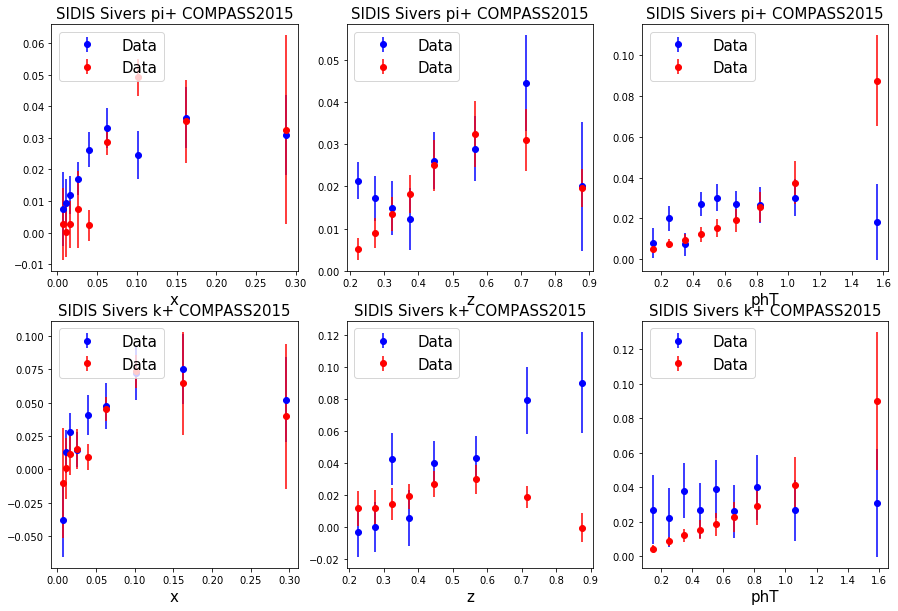

In [3]:

    
fig1=plt.figure(1,figsize=(15,10))
plt.subplot(2,3,1)
plotSivAsymmBands(numreplicas_SIDIS,'pi+','x')
plt.subplot(2,3,2)
plotSivAsymmBands(numreplicas_SIDIS,'pi+','z')
plt.subplot(2,3,3)
plotSivAsymmBands(numreplicas_SIDIS,'pi+','phT')
plt.subplot(2,3,4)
plotSivAsymmBands(numreplicas_SIDIS,'k+','x')
plt.subplot(2,3,5)
plotSivAsymmBands(numreplicas_SIDIS,'k+','z')
plt.subplot(2,3,6)
plotSivAsymmBands(numreplicas_SIDIS,'k+','phT')
#### Here the user needs to define the plot title based on the data set ####
plt.savefig('COMPASS2015Asymmetries_ANN.pdf', format='pdf', bbox_inches='tight')